In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as sc

import ipywidgets as widgets
from IPython.display import display

In [2]:
sep = '\n' + '-' * 30 +'\n'
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Input Data

Time and Financing

In [21]:
df = {}
timeframe = 110

#df['r = 0%'] = pd.DataFrame(index=np.arange(timeframe))
df['r = 4%'] = pd.DataFrame(index=np.arange(timeframe))
df['r = 7%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 10%'] = pd.DataFrame(index=np.arange(timeframe))

#df['r = 0%']['Taux d\'actualisation'] = 0.00;
df['r = 4%']['Taux d\'actualisation'] = 0.04;
df['r = 7%']['Taux d\'actualisation'] = 0.07;
#df['r = 10%']['Taux d\'actualisation'] = 0.1;

for key in df:
    df[key]["Année"] = df[key].index - 20

first_key = list(df.keys())[0]


Activated modules

In [22]:
b_construction = True
b_construction_profile = 'gaus' # [uniform], [gaus] or [user]
method_idc = 'ceu2008' # [ceu2008], [discount] or [direct]

b_production = True
b_production_fuelcost = True
b_production_omfix = False
b_production_omvar = True
b_production_waste = False

b_production_rd = True

b_refurbishment = True
b_dismantling = True

Time Frame

In [23]:
if b_production:
    production_period = 60
    production_start = 0
    production_stop  = production_start + production_period - 1
    for key in df:
        df[key]['Phase Production'] = np.where((df[key]['Année']>=production_start) & (df[key]['Année']<=production_stop), True, False)

if b_construction:
    construction_period = 6
    construction_start = production_start - construction_period
    construction_stop  = production_start - 1
    for key in df:
        df[key]['Phase Construction'] = np.where((df[key]['Année']>=construction_start) & (df[key]['Année']<=construction_stop), True, False)
    
if b_refurbishment:
    refurbishment_period = 10
    refurbishment_start = 40
    refurbishment_stop  = refurbishment_start + refurbishment_period - 1
    for key in df:
        df[key]['Phase Remise à Niveau'] = np.where((df[key]['Année']>=refurbishment_start) & (df[key]['Année']<=refurbishment_stop), True, False)

if b_dismantling:
    dismantling_period = 10
    dismantling_start = production_stop + 1
    dismantling_stop  = dismantling_start + dismantling_period - 1
    for key in df:
        df[key]['Phase Démantèlement'] = np.where((df[key]['Année']>=dismantling_start) & (df[key]['Année']<=dismantling_stop), True, False)
    

Project size

In [24]:
power_electric = 1.650e9
loadfactor = 0.90

Construction Costs [B €]

In [25]:
# Overnight Construction Cost 4000 or 4500 according to JGDDL 2021
cost_construction_occ = 4500 * power_electric * 1e-3
# Owner Cost [Haeseleer]
cost_construction_owner = 0.18 * cost_construction_occ
# Engineering,Procurement and Construction Cost [Haeseleer]
cost_construction_epcc = 0.71 * cost_construction_occ
# Contingency Provision [Haeseleer]
cost_construction_contingency = 0.11 * cost_construction_occ
# Interest During Construction
cost_construction_idc = 0

Other costs

In [26]:
# Fix Costs - Provision for dismantling - 15% du OCC
cost_dismantling = 0.15 * cost_construction_occ
# Fix Costs - Refurbishment - 600 € / kW -> To divide on the period
cost_refurbishment = 600 * power_electric / 1e3;
# Fix Costs - Staff, external consumption, Central functions, taxes - CdC 2014 : 120 €/kW
cost_fix_om = 110 * power_electric / 1e3;
cost_var_om = 13;
# Var Costs - Fuel cost
# -> CdC : 5.2 Euro / MWh
# -> Tableau ISTE [5 .. 14] Euro / MWh
# -> If 8 spent fuel included
cost_var_fuel = 8;
# Var Costs - Spent Fuel managment provisions 
# -> CdC : 4 Euro / MWh
# -> If fuel cost is spent fuel included, should be 0
cost_provisionspentfuel = 4;
# R&D cost [€ / MWh]
cost_rd = 2

# Profile Cost and Energy

Energy production

In [27]:
if b_production:
    for key in df:
        df[key]['Facteur de Charge'] = np.where(df[key]['Phase Production']==True,loadfactor,0)
        df[key]['Energie'] = power_electric * df[key]['Facteur de Charge'] * 1e-6 * 365.25 * 24.
        df[key]['Energie A'] = df[key]['Energie'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)

Construction

In [28]:
cost_construction_idc = {}

for key in df:
    df[key]['Phase Construction'] = np.where((df[key]['Année']>=construction_start) & (df[key]['Année']<=construction_stop), True, False)
    df[key]['Coût Construction']   = 0
    df[key]['Coût Construction A'] = 0
    df[key]['Interets Intercalaires'] = 0
    df[key]['Coût Construction Total'] = 0
    df[key]['Coût Construction Total Cum'] = 0
    cost_construction_idc[key] = 0
    if b_construction:
    
        # ----------------------------------------
        # Profile of construction costs
        # ----------------------------------------
        # Profile Uniform
        if b_construction_profile == 'uniform':
            df[key]['Coût Construction']   = np.where(df[key]['Phase Construction']==True,cost_construction_occ/construction_period,0)
            df[key]['Coût Construction A'] = df[key]['Coût Construction'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
    
        # Profile User (Here from D'Haeseleer table)
        if b_construction_profile == 'user':
            df[key].loc[15,'Coût Construction'] = 0.10 * cost_construction_occ
            df[key].loc[16,'Coût Construction'] = 0.25 * cost_construction_occ
            df[key].loc[17,'Coût Construction'] = 0.30 * cost_construction_occ
            df[key].loc[18,'Coût Construction'] = 0.25 * cost_construction_occ
            df[key].loc[19,'Coût Construction'] = 0.10 * cost_construction_occ
            df[key]['Coût Construction A'] = df[key]['Coût Construction'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
            if df[key]['Coût Construction'].astype(bool).sum(axis=0)!= construction_period:
                print('ERROR... construction period is different from cash flow dimension!')
            if df[key]['Coût Construction'].sum() != cost_construction_occ:
                print('ERROR... construction overnight cost should be equal to the sum of cash flow!')
    
        # Profile normal
        if b_construction_profile == 'gaus':
            m = (construction_start+construction_stop)/2
            s = construction_period / 3;
            df[key]['Coût Construction']   = np.where(df[key]['Phase Construction']==True,sc.norm.pdf(df[key]['Année']+0.5,m,s),0)
            df[key]['Coût Construction']   = df[key]['Coût Construction'] / df[key]['Coût Construction'].sum() * cost_construction_occ
            df[key]['Coût Construction A'] = df[key]['Coût Construction'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
    
        # ----------------------------------------
        # Interest During Construction calculation
        # ----------------------------------------
        # Formulae from European Commission showed in D'Haeseler - Ref is 30/06 of the year
        if method_idc == 'ceu2008':
            idc_fract = 0
            for t in df[key].index[df[key]['Phase Construction'] == True].tolist():
                idc_fract = idc_fract + df[key]['Coût Construction'][t]/cost_construction_occ * ((1+df[key]['Taux d\'actualisation'][t])**(-df[key]['Année'][t]-0.5) - 1)
            cost_construction_idc[key] = idc_fract * cost_construction_occ
                
        # Each steps of construction is used to calculate IDC (from D'Haeseleer table)
        if method_idc == 'direct':
            for t in df[key].index[df[key]['Phase Construction'] == True].tolist():
                df[key].loc[t,'Interets Intercalaires']  = df[key]['Taux d\'actualisation'][t-1] * df[key]['Coût Construction Total Cum'][t-1]
                df[key].loc[t,'Coût Construction Total'] = df[key]['Coût Construction'][t] + df[key]['Interets Intercalaires'][t]              
                df[key].loc[t,'Coût Construction Total Cum'] = df[key]['Coût Construction Total Cum'][t-1] + df[key]['Coût Construction Total'][t]
            # Add 6 month interest to FIT (Ref is 30/06 of the year) -> Slightly different from direct and discount approach.
            df[key].loc[t+1,'Interets Intercalaires'] = df[key]['Taux d\'actualisation'][t-1] * df[key]['Coût Construction Total Cum'][t-1] / 2.
            cost_construction_idc[key] = df[key]['Interets Intercalaires'].sum()
            idc_fract = cost_construction_idc[key] / cost_construction_occ
    
         # Discounting the construction cash-flow
        if method_idc == 'discount':
            cost_construction_idc[key] = df[key]['Coût Construction A'].sum() - df[key]['Coût Construction'].sum()
            idc_fract = cost_construction_idc[key]/cost_construction_occ


Production

In [29]:
for key in df:
    if b_production:
    
        # Fuel Cost
        if b_production_fuelcost:
            df[key]['Coût Combustible'] = cost_var_fuel * df[key]['Energie']
            df[key]['Coût Combustible A'] = df[key]['Coût Combustible'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
    
        # OM Fix
        if b_production_omfix:
            df[key]['Coût OM Fixe'] = np.where(df[key]['Phase Production']==True,cost_fix_om,0)
            df[key]['Coût OM Fixe A'] = df[key]['Coût OM Fixe'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
    
        # OM Var
        if b_production_omvar:
            df[key]['Coût OM Variable'] = cost_var_om * df[key]['Energie']
            df[key]['Coût OM Variable A'] = df[key]['Coût OM Variable'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
    
        # Waste provision
        if b_production_waste:
            df[key]['Coût Déchet'] = cost_provisionspentfuel * df[key]['Energie']
            df[key]['Coût Déchet A'] = df[key]['Coût Déchet'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
    
        # R&D
        if b_production_rd:
            df[key]['Coût R&D'] = cost_rd * df[key]['Energie']
            df[key]['Coût R&D A'] = df[key]['Coût R&D'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)

Refurbishment

In [30]:
for key in df:
    if b_refurbishment:
        df[key]['Coût Remise à Niveau'] = np.where(df[key]['Phase Remise à Niveau']==True,cost_refurbishment/refurbishment_period,0)
        df[key]['Coût Remise à Niveau A'] = df[key]['Coût Remise à Niveau'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)

Dismantling

In [31]:
for key in df:
    if b_dismantling:
        df[key]['Coût Démantèlement'] = np.where(df[key]['Phase Démantèlement']==True,cost_dismantling/dismantling_period,0)
        df[key]['Coût Démantèlement A'] = df[key]['Coût Démantèlement'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)

# Plotting

Energy

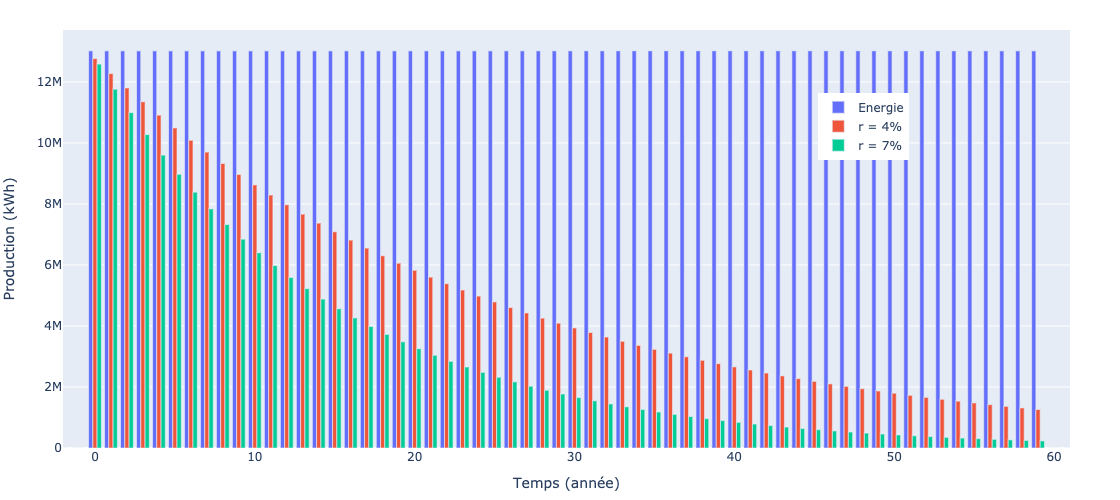

In [32]:
fig = go.Figure()

if b_production:
    fig.add_trace(go.Bar(
        name="Energie",
        x=df[first_key]["Année"], y=df[first_key]["Energie"]
    ))
    for key in df:
        fig.add_trace(go.Bar(name=key,x=df[key]["Année"], y=df[key]["Energie A"]))

fig.update_layout(title="",
                  xaxis_title="Temps (année)",
                  yaxis_title="Production (kWh)",
                  width=1000,
                  height=500,
                  margin=dict(l=50,r=50,b=30,t=30),
                  legend=dict(y=0.85,x=0.75)
                 )
fig.update_xaxes(range=[production_start-2,production_stop+2])

### Construction et intérêts intercalaires

In [33]:
fig = go.Figure()
if b_construction:
    if method_idc == 'direct':

        fig.add_trace(go.Bar(name="Construction",x=df[first_key]["Année"],y=df[first_key]["Coût Construction"]))
        for key in df:
            fig.add_trace(go.Bar(name='Intérêts Intercalaires - '+key,x=df[key]["Année"],y=df[key]["Interets Intercalaires"]))        
            #print(df[key]["Coût Construction"].sum()*1e-9,df[key]["Interets Intercalaires"].sum()*1e-9)
            
        fig.update_layout(#barmode='stack',
                          xaxis_title="Temps (année)",
                          yaxis_title="Dépense annuelle (€)",
                          width=1000,
                          height=500,
                          margin=dict(l=50,r=50,b=30,t=30),
                          legend=dict(y=0.95,x=0.70)
                          )
        fig.update_xaxes(range=[construction_start-2,construction_stop+2])
        fig.show()



Cash Flows

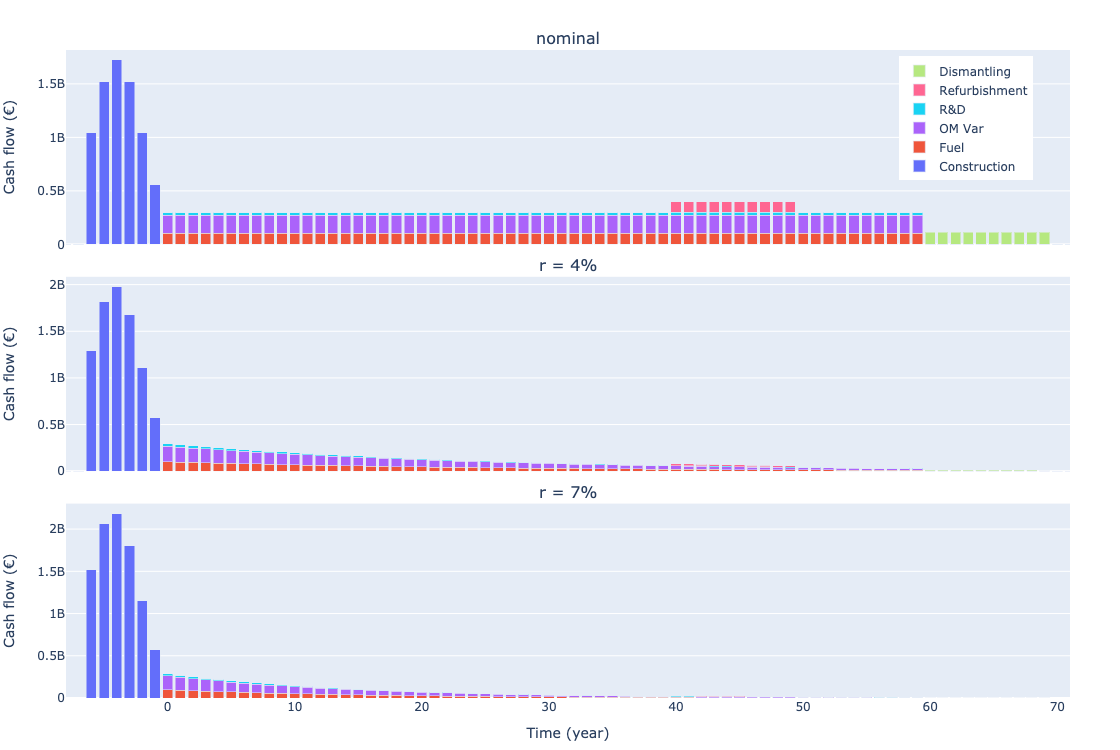

In [35]:
titles = list(df)
titles.insert(0, 'nominal')

fig = make_subplots(rows=len(df)+1, cols=1,shared_xaxes=True,vertical_spacing=0.05,subplot_titles=titles)

if b_construction:
    fig.add_trace(go.Bar(name="Construction",x=df[first_key]["Année"],y=df[first_key]["Coût Construction"],marker_color='#636EFA'),row=1,col=1)
    for index, key in enumerate(df):
        fig.add_trace(go.Bar(name="Construction",x=df[key]["Année"],y=df[key]["Coût Construction A"],marker_color='#636EFA',showlegend=False),row=2+index,col=1)        

if b_production:
    if b_production_fuelcost:
        fig.add_trace(go.Bar(name="Combustible",x=df[first_key]["Année"],y=df[first_key]["Coût Combustible"],marker_color='#EF553B'),row=1,col=1)
        for index, key in enumerate(df):
            fig.add_trace(go.Bar(name="Combustible A.",x=df[key]["Année"],y=df[key]["Coût Combustible A"],marker_color='#EF553B',showlegend=False),row=2+index,col=1)
    if b_production_omfix:
        fig.add_trace(go.Bar(name="OM Fixe",x=df[first_key]["Année"],y=df[first_key]["Coût OM Fixe"],marker_color='#00CC96'),row=1,col=1)
        for index, key in enumerate(df):
            fig.add_trace(go.Bar(name="OM Fixe A.",x=df[key]["Année"],y=df[key]["Coût OM Fixe A"],marker_color='#00CC96',showlegend=False),row=2+index,col=1)
    if b_production_omvar:
        fig.add_trace(go.Bar(name="OM Variable",x=df[first_key]["Année"],y=df[first_key]["Coût OM Variable"],marker_color='#AB63FA'),row=1,col=1)
        for index, key in enumerate(df):
            fig.add_trace(go.Bar(name="OM Variable A.",x=df[key]["Année"],y=df[key]["Coût OM Variable A"],marker_color='#AB63FA',showlegend=False),row=2+index,col=1)
    if b_production_waste:
        fig.add_trace(go.Bar(name="Déchet",x=df[first_key]["Année"],y=df[first_key]["Coût Déchet"],marker_color='#FFA15A'),row=1,col=1)
        for index, key in enumerate(df):
            fig.add_trace(go.Bar(name="Déchet A.",x=df[key]["Année"],y=df[key]["Coût Déchet A"],marker_color='#FFA15A',showlegend=False),row=2+index,col=1)
    if b_production_rd:
        fig.add_trace(go.Bar(name="R&D",x=df[first_key]["Année"],y=df[first_key]["Coût R&D"],marker_color='#19D3F3'),row=1,col=1)
        for index, key in enumerate(df):
            fig.add_trace(go.Bar(name="R&D A.",x=df[key]["Année"],y=df[key]["Coût R&D A"],marker_color='#19D3F3',showlegend=False),row=2+index,col=1)

if b_refurbishment:
    fig.add_trace(go.Bar(name="Remise à Niveau",x=df[first_key]["Année"],y=df[first_key]["Coût Remise à Niveau"],marker_color='#FF6692'),row=1,col=1)
    for index, key in enumerate(df):
        fig.add_trace(go.Bar(name="Remise à Niveau A.",x=df[key]["Année"],y=df[key]["Coût Remise à Niveau A"],marker_color='#FF6692',showlegend=False),row=2+index,col=1)

if b_dismantling:
    fig.add_trace(go.Bar(name="Démantèlement",x=df[first_key]["Année"],y=df[first_key]["Coût Démantèlement"],marker_color='#B6E880'),row=1,col=1)
    for index, key in enumerate(df):
        fig.add_trace(go.Bar(name="Démantèlement A.",x=df[key]["Année"],y=df[key]["Coût Démantèlement A"],marker_color='#B6E880',showlegend=False),row=2+index,col=1)

fig.update_xaxes(title="Temps (année)",row=2+index)
fig.update_yaxes(title="Dépense annuelle (€)")
    
fig.update_layout(barmode='stack',
                  width=1000,
                  height=250*(len(df)+1),
                  margin=dict(l=50,r=50,b=30,t=50),
                  legend=dict(y=0.99,x=0.83))

fig.update_xaxes(range=[construction_start-2,dismantling_stop+2])
fig.show()


# LCOE Calculation and Share plot


 Phases et données :  

	 - Construction: 4500.0  €/kW
		 * Profile: gaus
		 * Méthode IDC: ceu2008
	 - Production
		 * Combustible: 8  €/MWh
		 * OM Fix: 110.0  €/kW
		 * OM Var: 13  €/MWh
	 - R&D: 2  € / MWh
	 - Remise à Niveau: 600.0  €/kW
	 - Démantèlement: 15.0  % OCC




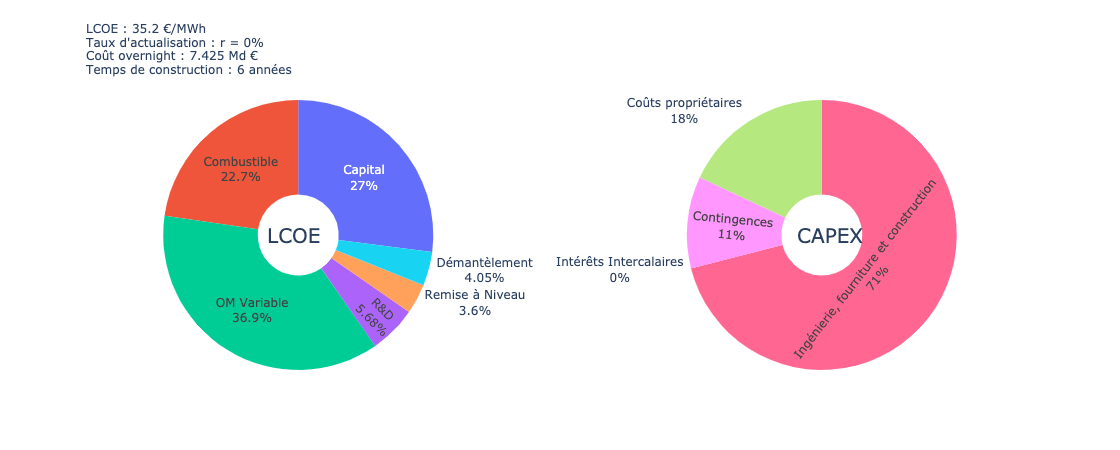




 Phases et données :  

	 - Construction: 4500.0  €/kW
		 * Profile: gaus
		 * Méthode IDC: ceu2008
	 - Production
		 * Combustible: 8  €/MWh
		 * OM Fix: 110.0  €/kW
		 * OM Var: 13  €/MWh
	 - R&D: 2  € / MWh
	 - Remise à Niveau: 600.0  €/kW
	 - Démantèlement: 15.0  % OCC




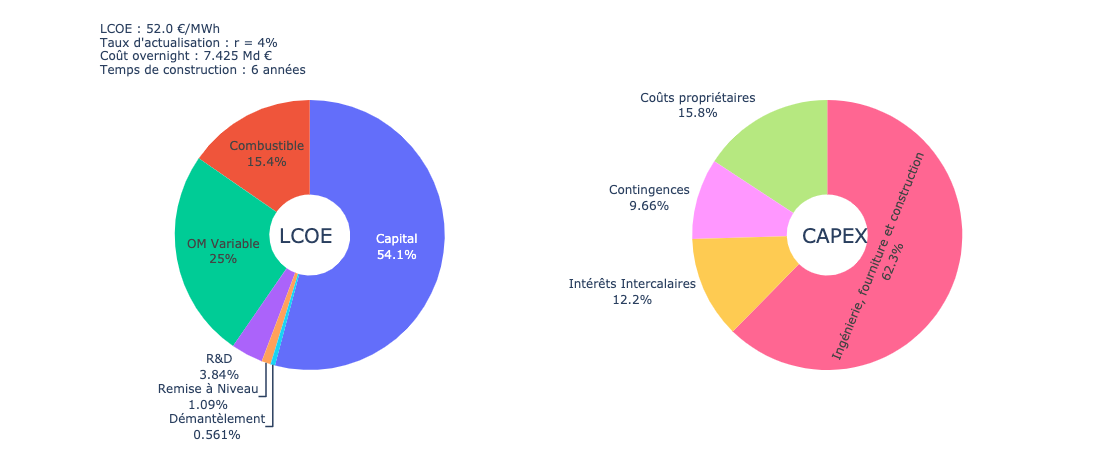




 Phases et données :  

	 - Construction: 4500.0  €/kW
		 * Profile: gaus
		 * Méthode IDC: ceu2008
	 - Production
		 * Combustible: 8  €/MWh
		 * OM Fix: 110.0  €/kW
		 * OM Var: 13  €/MWh
	 - R&D: 2  € / MWh
	 - Remise à Niveau: 600.0  €/kW
	 - Démantèlement: 15.0  % OCC




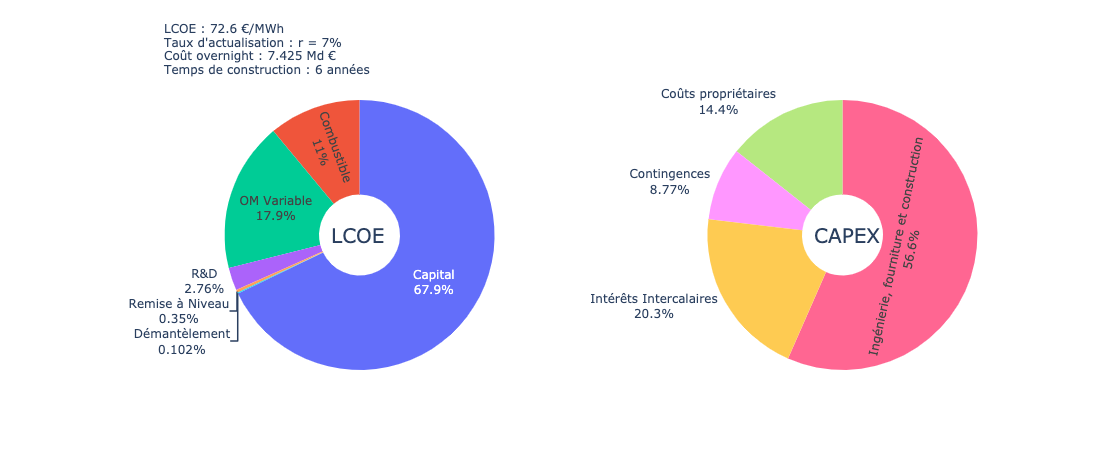

In [17]:
for key in df:
    cost_s = {}
    labels_lcoe = []
    values_lcoe = []
    
    if b_construction:
        labels_lcoe.append('Capital')
        values_lcoe.append(df[key]["Coût Construction A"].sum())
        
        labels_cap = ['Ingénierie, fourniture et construction','Coûts propriétaires','Contingences','Intérêts Intercalaires']
        values_cap = [cost_construction_epcc,cost_construction_owner,cost_construction_contingency,cost_construction_idc[key]]
    
    if b_production:
        if b_production_fuelcost:
            labels_lcoe.append('Combustible')
            values_lcoe.append(df[key]["Coût Combustible A"].sum())        
        if b_production_omfix:
            labels_lcoe.append('OM Fixe')
            values_lcoe.append(df[key]["Coût OM Fixe A"].sum())        
        if b_production_omvar:
            labels_lcoe.append('OM Variable')
            values_lcoe.append(df[key]["Coût OM Variable A"].sum())        
        if b_production_waste:
            labels_lcoe.append('Déchet')
            values_lcoe.append(df[key]["Coût Déchet A"].sum())        
        if b_production_rd:
            labels_lcoe.append('R&D')
            values_lcoe.append(df[key]["Coût R&D A"].sum())        
    
    if b_refurbishment:
        labels_lcoe.append('Remise à Niveau')
        values_lcoe.append(df[key]["Coût Remise à Niveau A"].sum())
    if b_dismantling:
        labels_lcoe.append('Démantèlement')
        values_lcoe.append(df[key]["Coût Démantèlement A"].sum())
    
    if df[key]["Energie A"].sum() > 0:
        LCOE = sum(values_lcoe)/df[key]["Energie A"].sum()
    
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")
    fig.update_traces(insidetextorientation='horizontal')
    
    fig.add_trace(go.Pie(labels=labels_lcoe, values=values_lcoe, name="LCOE", textinfo='label+percent',hole=.3,sort =False),1, 1)
    fig.add_trace(go.Pie(labels=labels_cap, values=values_cap, name="CAPEX", textinfo='label+percent',hole=.3,sort =False),1, 2)
    
    fig.update_layout(title='',showlegend=False,
                      annotations=[dict(text='LCOE', x=0.19, y=0.5, font_size=20, showarrow=False),
                                   dict(text='CAPEX', x=0.82, y=0.5, font_size=20, showarrow=False)])
    
    fig.add_annotation(text='LCOE : '+str(round(LCOE, 1))+' €/MWh',xref="paper", yref="paper",x=0.0, y=1.30, showarrow=False)
    fig.add_annotation(text='Taux d\'actualisation : '+key,xref="paper", yref="paper",x=0.0, y=1.25, showarrow=False)
    fig.add_annotation(text='Coût overnight : '+str(cost_construction_occ/1e9)+' Md €',xref="paper", yref="paper",x=0.0, y=1.20, showarrow=False)
    fig.add_annotation(text='Temps de construction : '+str(construction_period)+' années',xref="paper", yref="paper",x=0.0, y=1.15, showarrow=False)

    print('\n','Phases et données : ','\n')
    if b_construction:
        print('\t - Construction:',cost_construction_occ/ power_electric * 1e3,' €/kW')
        print('\t\t * Profile:',b_construction_profile)
        print('\t\t * Méthode IDC:',method_idc)
    if b_production:
        print('\t - Production')
        print('\t\t * Combustible:',cost_var_fuel,' €/MWh')
        print('\t\t * OM Fix:',cost_fix_om / power_electric * 1e3,' €/kW')
        print('\t\t * OM Var:',cost_var_om,' €/MWh')        
    if b_production_waste:
        print('\t - Déchets:',cost_provisionspentfuel,' €/MWh')
    if b_production_rd:
        print('\t - R&D:',cost_rd,' € / MWh')
    if b_refurbishment:
        print('\t - Remise à Niveau:',cost_refurbishment / power_electric * 1e3,' €/kW')
    if b_dismantling:
        print('\t - Démantèlement:',cost_dismantling / cost_construction_occ *100,' % OCC')
    print('\n')

    fig.show()
    print('\n')

# Sensibilité

In [18]:
data = [
        [4300, 50.8, 70.4],
        [4400, 0, 0],
        [4500, 0, 0],
        [4600, 0, 0],
        [4700, 0, 0],
        [4800, 0, 0],
        [4900, 0, 0],
        [5000, 0, 0],
        [5100, 0, 0],
        [5200, 0, 0],
        [5300, 0, 0]
       ]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['OCC', 'LCOE-4','LCOE-7'])

df

,OCC,LCOE-4,LCOE-7
0,4300,50.8,70.4
1,4400,0.0,0.0
2,4500,0.0,0.0
3,4600,0.0,0.0
4,4700,0.0,0.0
5,4800,0.0,0.0
6,4900,0.0,0.0
7,5000,0.0,0.0
8,5100,0.0,0.0
9,5200,0.0,0.0
